In [7]:
import sys
sys.path.insert(0,"/home/apprenant/PycharmProjects/pythonProject/foodflix")


In [8]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image, HTML
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

#from src.more_utils import *

In [32]:
# Importing the dataset
df = pd.read_csv('/home/apprenant/PycharmProjects/pythonProject/foodflix/File/02_Cleaned/food_facts_fr.csv')

#df = df.rename(columns={ df.columns[0]: "index" })
df.reset_index(inplace=True)
df.head(2)

,index,product_name,quantity,packaging,packaging_tags,brands,categories,categories_tags,categories_en,countries_en,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0,farine de blé noir,1kg,NaN,NaN,ferme t'y r'nao,NaN,NaN,NaN,france,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,naturablue original,250ml,NaN,NaN,natura4ever,NaN,NaN,NaN,france,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df.columns.tolist()

['index',
 'product_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'categories',
 'categories_tags',
 'categories_en',
 'countries_en',
 'ingredients_text',
 'additives_n',
 'additives',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states_en',
 'main_category',
 'main_category_en',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
 'content']

In [10]:
#df=df[['index','product_name','brands']]

## Exploratory Data Analysis
Are there certain words that figure more often in listings' name and description? I suspect there are some words which are occured more frequently and considered more worthy of a title. Let us find out!

In [11]:
df.dtypes

index            int64
product_name    object
brands          object
dtype: object

In [12]:
df['product_name']=df['product_name'].astype('str')
name_corpus = ' '.join(df['product_name'])

In [13]:
fr_STOPWORDS = ['d', 'base', 'MG', 'du', 'nan', 'de', 'la', 'des', 'le', 'et', 'est', 'elle', 'une', 'en', 'que', 'aux', 'qui', 'ces', 'les', 'dans', 'sur', 'l', 'un', 'pour', 'par', 'il', 'ou', 'à', 'ce', 'a', 'sont', 'cas', 'plus', 'leur', 'se', 's', 'vous', 'au', 'c', 'aussi', 'toutes', 'autre', 'comme']

(-0.5, 3999.5, 1999.5, -0.5)

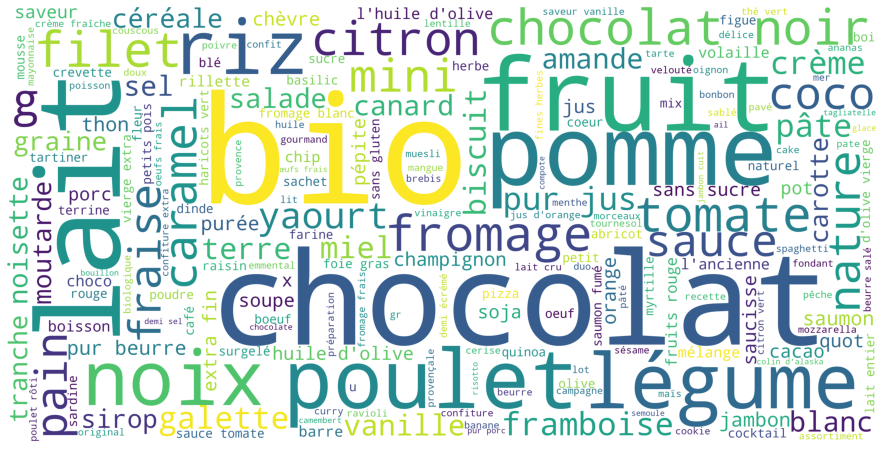

In [14]:
name_wordcloud = WordCloud(stopwords = fr_STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(name_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
# plt.show()

Now, we create a column containing a combination of name and description columns that is important for content-based recommendation system

In [34]:
df['content'] = df[['product_name','brands']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [35]:
# Fillna
df['content'].fillna('Null', inplace = True)

## Train the Recommender

## TF-IDF (Term Frequency - Inverse Document Frequency)
Create a TF-IDF matrix of unigrams and bigrams for each id or room. The “stop words” parameter tells the TF-IDF module to ignore common English words like 'the', ‘about’, etc.  TF-IDF will parse through the descriptions, identify distinct phrases in each item's description, and then find similar contents based on those phrases. Formula is below:

In [17]:
df.head()

,index,product_name,brands,content
0,0,farine de blé noir,ferme t'y r'nao,farine de blé noir // ferme t'y r'nao
1,1,naturablue original,natura4ever,naturablue original // natura4ever
2,2,filet de bœuf,NaN,filet de bœuf // nan
3,3,nan,NaN,nan // nan
4,4,naturakrill original,natura4ever,naturakrill original // natura4ever


In [18]:
vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')

In [19]:
vectors_content = vectorizer.fit_transform(df['content'])
vectors_product = vectorizer.transform(['Blanc de poulet'])

In [20]:
feature_names = vectorizer.get_feature_names()

In [21]:
print(vectors_product)

  (0, 172167)	0.476751404471602
  (0, 29361)	0.7217721877239486
  (0, 28947)	0.5017499450548452


## Cosine Similarity
Cosine Similarity calculates similarity by measuring the cosine angle between two vectors. Vectors are converted from contents by TF-IDF and this measurement will identify which contents are closest to each other.


In [22]:
cosine_similarities = linear_kernel(vectors_product,vectors_content)

In [23]:
print(cosine_similarities)

[[0. 0. 0. ... 0. 0. 0.]]


Iterate through each item's similar items and store the 100 most-similar!

In [24]:
results = {}   
similar_indices = cosine_similarities[0].argsort()[:-10:-1]
similar_items = [(cosine_similarities[0][i], df['index'][i]) for i in similar_indices]

## Let's make a prediction

Create two functions for showing the recommender results:
1. Function to get a friendly item name and description from the content field, given an item ID
2. Function to read the results out of the dictionary

In [25]:
def item(id):
    name   = df.loc[df['index'] == id]['content'].tolist()[0].split(' // ')[0]
    cat   = ' \nCategories: ' + df.loc[df['index'] == id]['content'].tolist()[0].split(' // ')[1][0:165] + '...'
    prediction = name  + cat
    return prediction

def recommend(item_id, num):
    print('Recommending ' + str(num) + ' products similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

Finally, try to put an id from listings data and number of recommendation to show

# II TF-IDF

In [26]:
def recotfidf(user_input):
    vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
    vectors_content = vectorizer.fit_transform(df['content'])
    vectors_product = vectorizer.transform([user_input])
    cosine_similarities = linear_kernel(vectors_product,vectors_content)
    similar_indices = cosine_similarities[0].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[0][i], df['index'][i]) for i in similar_indices]
    return similar_items


In [27]:
# on entre un produit
product = input()
print(product)

results = recotfidf(product)
#on affiche les produits similaires
for i in range(4):
    print(df.iloc[results[i][1]])
    print("----------------------")

chat
index                                  65221
product_name                 langues de chat
brands                             carrefour
content         langues de chat // carrefour
Name: 65221, dtype: object
----------------------
index                               32858
product_name              langues de chat
brands                             auchan
content         langues de chat // auchan
Name: 32858, dtype: object
----------------------
index                               23111
product_name              langues de chat
brands                             casino
content         langues de chat // casino
Name: 23111, dtype: object
----------------------
index                                 28317
product_name                langues de chat
brands                             monoprix
content         langues de chat // monoprix
Name: 28317, dtype: object
----------------------


# III Countvectorizer

In [28]:
def recocount(user_input):
    cv=CountVectorizer()
    vectors_content=cv.fit_transform(df['content'])
    vectors_product=cv.transform([user_input])
    cosine_similarities=linear_kernel(vectors_product,vectors_content)
    similar_indices = cosine_similarities[0].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[0][i], df['index'][i]) for i in similar_indices]
    return similar_items

In [29]:
# on entre un produit
product = input()
print(product)

results = recocount(product)
#on affiche les produits similaires
for i in range(4):
    print(df.iloc[results[i][1]])
    print("----------------------")


chat
index                                                       50484
product_name    beurre de baratte au lait pasteurisé la dent d...
brands                                            la dent du chat
content         beurre de baratte au lait pasteurisé la dent d...
Name: 50484, dtype: object
----------------------
index                                   27115
product_name                  langues de chat
brands                             grand jury
content         langues de chat // grand jury
Name: 27115, dtype: object
----------------------
index                                                 68236
product_name                                langues de chat
brands                             p'tit déli,marque repère
content         langues de chat // p'tit déli,marque repère
Name: 68236, dtype: object
----------------------
index                             36796
product_name            langues de chat
brands                             cora
content         langues de chat // co